In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm,

import seaborn as sns; sns.set()

from pandas.core import datetools
%matplotlib inline


# Data Acquisition
The following code imports and validates the LendingClub data.

In [2]:
converters = dict(
    id=str,
    desc=str,
    hardship_type=str,
    hardship_reason=str,
    hardship_status=str,
    hardship_loan_status=str,
    verification_status_joint=str
)
dates = [
    'next_pymnt_d',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'earliest_cr_line',
    'issue_d'
]

In [3]:
# Imports loan data

df = pd.DataFrame()
basepath='./Source Data/Loan Data/'
files = os.listdir(basepath)
csvs = []

for file in files:
    if re.match('.*csv$',file):
        csvs += [file]

if 0:
    #ignore this - was trying to pickle the data into
    #formats like feather, hdf5, native python pickling, etc
    # but found issues on python 3.7
    df=pd.read_pickle(basepath+'df.pkl')
else:
    cols = df.dtypes
    for csv in csvs:
        path = basepath + csv
        print("Reading",path)
        tdf = pd.read_csv(path,header=1,low_memory=False)
        df=df.append(tdf)
    
df.reset_index(inplace=True) # This will help with joining back data if necessary.

print(df.shape)

Reading ./Source Data/Loan Data/LoanStats3a_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3b_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3c_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3d_securev1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2018Q1.csv
(1873317, 152)


In [4]:
pd.set_option('display.max_rows', 200)
print(df.dtypes)
pd.set_option('display.max_rows', 200)

index                                           int64
id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                  

In [5]:
# Checks for duplicates within our combined data
df['count']=1 # Generate field to measure the number of occurances

counts = df.groupby('id')['count'].count()
print('Data are duplicated %i times.' % len(counts[counts>1]))

Data are duplicated 0 times.


Data are duplicated 0 times.

Some data are not useful as a predictor. Because we are going to use these data as a training set, we need to remove data that are not useful for predictions. There are two categories of data that are not useful for predictions. First, we need information about loans that have fully run their course. That is to say, we need to see loans that have either been paid in full or written off. It is not useful to see loans that are currently delinquent or current on payments but still early in the loan. Second, we need to remove predictors that are not import for predicting the loan. For example the URL has no impact on the borrower's ability to repay the loan. If we need this data in the future, we can still pair it back with the original dataframe.

In [6]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())
#print(len(has_data))
#has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=50
for i,j in zip(order_has_data[0:top_sparse],range(top_sparse)):
    print(j, i, has_data[i])

0 member_id 0
1 orig_projected_additional_accrued_interest 5846
2 hardship_type 7288
3 hardship_reason 7288
4 hardship_status 7288
5 deferral_term 7288
6 hardship_amount 7288
7 hardship_start_date 7288
8 hardship_end_date 7288
9 payment_plan_start_date 7288
10 hardship_length 7288
11 hardship_dpd 7288
12 hardship_loan_status 7288
13 hardship_payoff_balance_amount 7288
14 hardship_last_payment_amount 7288
15 sec_app_mths_since_last_major_derog 18992
16 debt_settlement_flag_date 21652
17 settlement_status 21652
18 settlement_date 21652
19 settlement_amount 21652
20 settlement_percentage 21652
21 settlement_term 21652
22 sec_app_revol_util 54417
23 revol_bal_joint 55366
24 sec_app_fico_range_low 55367
25 sec_app_fico_range_high 55367
26 sec_app_earliest_cr_line 55367
27 sec_app_inq_last_6mths 55367
28 sec_app_mort_acc 55367
29 sec_app_open_acc 55367
30 sec_app_open_act_il 55367
31 sec_app_num_rev_accts 55367
32 sec_app_chargeoff_within_12_mths 55367
33 sec_app_collections_12_mths_ex_med 5

Based on the data, it appears that joint applications are a fairly new development in these data. We see only about 50,000 instances where the data are included for joint applications. The following visualization shows the relationship for income in joint applicants.

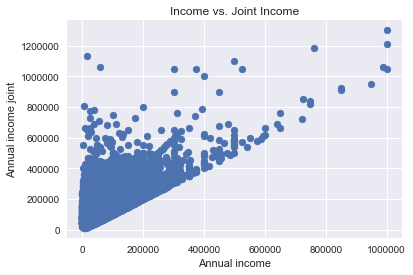

In [7]:
joint_fil = (df['annual_inc']>0)&(df['annual_inc_joint']>0)
plt.scatter(df[joint_fil]['annual_inc'],df[joint_fil]['annual_inc_joint'])
plt.title('Income vs. Joint Income')
plt.xlabel('Annual income')
plt.ylabel('Annual income joint')
plt.show;


Because of the high risk of multicolinearity, and the small number of observations, we are dropping this from the dataset. We will still keep a dummy variable that treats joint applications differently, but we will not consider the joint income of applicants.

In [8]:
# Convert dates to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

#determine age of credit line prior to loan issue and convert to integer
# days of credit history
df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days

# convert issue_d to a year to consider economic conditions
#SHOULD WE GO TO QUARTERS?
df['issue_d'] = df['issue_d'].dt.year

In [9]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data

mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
reduced_df=reduced_df[features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2

reduced_df.drop(columns=['fico_range_low','fico_range_high'],inplace=True)
print(reduced_df.shape)

(1020552, 73)


In [10]:
# backup our df
backup_df = reduced_df.copy()

In [11]:
#restore our df
reduced_df = backup_df.copy()

In [12]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

grade_map={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7}
reduced_df['grade']=reduced_df['grade'].replace(pd.Series(grade_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x:
                                                        x[:-1] if isinstance(x, str) else np.nan).astype(float)

reduced_df['earliest_cr_line']=reduced_df['earliest_cr_line'].apply(lambda x:
                                                        0.0 if np.isnan(x) else x)

reduced_df.drop(columns=['emp_title'],inplace=True)

print(reduced_df.shape)

(1020552, 72)


# Which values are categorical?

In [13]:
n_options = {}
for column in reduced_df.columns:
    n_options[column] = len(reduced_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:50]:
    print(i, n_options[i],reduced_df[i].unique())

out_prncp 1 [0.]
out_prncp_inv 1 [0.]
application_type 2 ['Individual' 'Joint App']
term 2 [' 36 months' ' 60 months']
verification_status 3 ['Verified' 'Source Verified' 'Not Verified']
home_ownership 6 ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
grade 7 [2 3 1 5 6 4 7]
inq_last_6mths 10 [ 1.  5.  2.  0.  3.  4.  6.  7.  8. nan]
chargeoff_within_12_mths 11 [ 0. nan  1.  2.  3.  4.  5.  7.  6. 10.  8.]
emp_length 12 [10.  0.  1.  3.  8.  9.  4.  5.  6.  2.  7. nan]
issue_d 12 [2011. 2010. 2009. 2008. 2007. 2013. 2012. 2014. 2015. 2016. 2017. 2018.]
pub_rec_bankruptcies 13 [ 0.  1.  2. nan  4.  3.  8.  5.  6.  7. 12.  9. 11.]
purpose 14 ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
collections_12_mths_ex_med 15 [ 0. nan  1.  2.  4.  3.  6. 16. 20.  5. 10. 14.  7. 12.  9.]
open_il_12m 19 [nan  0.  2.  1.  3.  4.  6.  5.  9.  7.  8. 10. 12. 11. 13

Based on these results, we will have to encode several data as dummy variables:

- application_type
- term
- verification_status
- home_ownership
- purpose


In [14]:
seta=set(reduced_df.columns)

reduced_df=pd.get_dummies(data=reduced_df,columns=['application_type','term',
                                                   'verification_status',
                                                   'home_ownership','purpose'],
                          drop_first=True)


setb=set(reduced_df.columns)
print(setb-seta)
print(reduced_df.shape)

{'home_ownership_MORTGAGE', 'purpose_credit_card', 'home_ownership_RENT', 'purpose_wedding', 'home_ownership_NONE', 'term_ 60 months', 'purpose_small_business', 'purpose_house', 'purpose_vacation', 'home_ownership_OWN', 'application_type_Joint App', 'purpose_other', 'purpose_debt_consolidation', 'purpose_medical', 'purpose_major_purchase', 'purpose_renewable_energy', 'purpose_educational', 'verification_status_Verified', 'verification_status_Source Verified', 'purpose_home_improvement', 'home_ownership_OTHER', 'purpose_moving'}
(1020552, 89)


# How to treat NaN?

For now, let's remove majority NaN columns...

In [15]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=25
for i,j in zip(range(top_sparse),order_has_data[0:top_sparse]):
    print(i,j, has_data[j])

0 annual_inc_joint 9529
1 dti_joint 9529
2 mths_since_last_record 172185
3 mths_since_recent_bc_dlq 240759
4 mths_since_last_major_derog 264308
5 mths_since_rcnt_il 289098
6 all_util 296067
7 inq_last_12m 296092
8 open_acc_6m 296092
9 total_cu_tl 296092
10 inq_fi 296093
11 open_il_12m 296093
12 open_il_24m 296093
13 open_rv_12m 296093
14 open_rv_24m 296093
15 mths_since_recent_revol_delinq 338379
16 mths_since_last_delinq 503506
17 mths_since_recent_inq 881746
18 mo_sin_old_il_acct 924972
19 pct_tl_nvr_dlq 952881
20 mo_sin_old_rev_tl_op 953024
21 mo_sin_rcnt_rev_tl_op 953024
22 num_rev_accts 953024
23 mo_sin_rcnt_tl 953025
24 num_accts_ever_120_pd 953025


In [16]:
nonnan_df=reduced_df.drop(columns=order_has_data[0:19])
print(nonnan_df.shape)

(1020552, 70)


In [17]:
print(len(reduced_df.dropna()),len(nonnan_df.dropna()))
nonnan_df=nonnan_df.dropna()
print(nonnan_df.shape)

n_options = {}
for column in nonnan_df.columns:
    n_options[column] = len(nonnan_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:49]:
    print(i, n_options[i],nonnan_df[i].unique())

191 890319
(890319, 70)
out_prncp 1 [0.]
out_prncp_inv 1 [0.]
application_type_Joint App 2 [0 1]
term_ 60 months 2 [1 0]
verification_status_Source Verified 2 [0 1]
verification_status_Verified 2 [1 0]
home_ownership_MORTGAGE 2 [0 1]
home_ownership_NONE 2 [0 1]
home_ownership_OTHER 2 [0 1]
home_ownership_OWN 2 [0 1]
home_ownership_RENT 2 [1 0]
purpose_credit_card 2 [0 1]
purpose_debt_consolidation 2 [1 0]
purpose_educational 2 [0 1]
purpose_home_improvement 2 [0 1]
purpose_house 2 [0 1]
purpose_major_purchase 2 [0 1]
purpose_medical 2 [0 1]
purpose_moving 2 [0 1]
purpose_other 2 [0 1]
purpose_renewable_energy 2 [0 1]
purpose_small_business 2 [0 1]
purpose_vacation 2 [0 1]
purpose_wedding 2 [0 1]
grade 7 [5 1 2 3 4 6 7]
issue_d 7 [2013. 2012. 2014. 2015. 2016. 2017. 2018.]
inq_last_6mths 9 [0. 1. 2. 4. 3. 5. 6. 7. 8.]
chargeoff_within_12_mths 10 [ 0.  1.  2.  3.  4.  5.  6.  7. 10.  8.]
emp_length 11 [ 4.  5. 10.  2.  7.  3.  6.  1.  8.  9.  0.]
pub_rec_bankruptcies 12 [ 0.  1.  2.  4. 

# What factors are correlated?

In [18]:
#correlatable columns
corr_columns = order_n_options[24:]
print(nonnan_df[corr_columns].dtypes)

grade                           int64
issue_d                       float64
inq_last_6mths                float64
chargeoff_within_12_mths      float64
emp_length                    float64
pub_rec_bankruptcies          float64
collections_12_mths_ex_med    float64
num_tl_90g_dpd_24m            float64
delinq_2yrs                   float64
num_tl_op_past_12m            float64
tax_liens                     float64
pub_rec                       float64
mort_acc                      float64
num_accts_ever_120_pd         float64
fico_est                      float64
num_rev_tl_bal_gt_0           float64
num_bc_sats                   float64
acc_open_past_24mths          float64
num_bc_tl                     float64
num_op_rev_tl                 float64
num_sats                      float64
open_acc                      float64
num_rev_accts                 float64
num_il_tl                     float64
mo_sin_rcnt_tl                float64
percent_bc_gt_75              float64
mo_sin_rcnt_

Factors with high correlation (> +/-0.7) are:
	 0 grade vs int_rate = 0.9557356130347155
	 1 num_tl_op_past_12m vs acc_open_past_24mths = 0.7535829314915097
	 2 num_rev_tl_bal_gt_0 vs num_op_rev_tl = 0.7919957423493177
	 3 num_bc_sats vs num_bc_tl = 0.7054466864393747
	 4 num_bc_sats vs num_op_rev_tl = 0.7353826032302152
	 5 acc_open_past_24mths vs num_tl_op_past_12m = 0.7535829314915098
	 6 num_bc_tl vs num_bc_sats = 0.7054466864393748
	 7 num_bc_tl vs num_rev_accts = 0.8379284529069836
	 8 num_op_rev_tl vs num_rev_tl_bal_gt_0 = 0.7919957423493176
	 9 num_op_rev_tl vs num_bc_sats = 0.7353826032302151
	 10 num_op_rev_tl vs num_sats = 0.8231132793215286
	 11 num_op_rev_tl vs open_acc = 0.8239210002829699
	 12 num_op_rev_tl vs num_rev_accts = 0.7681758790039788
	 13 num_sats vs num_op_rev_tl = 0.8231132793215286
	 14 num_sats vs open_acc = 0.9987131432670138
	 15 open_acc vs num_op_rev_tl = 0.8239210002829699
	 16 open_acc vs num_sats = 0.998713143267014
	 17 num_rev_accts vs num_bc_tl =

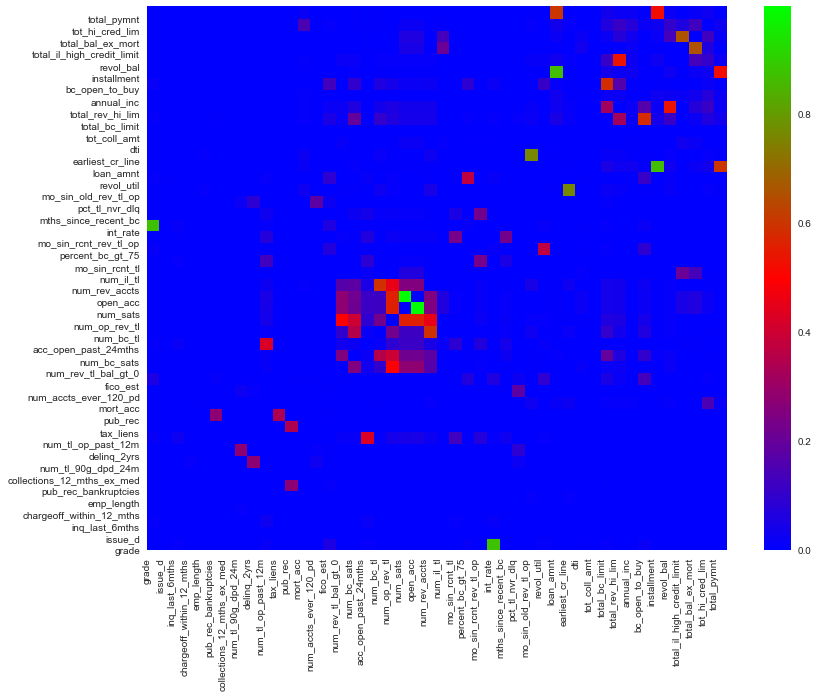

In [19]:
corr_df=nonnan_df[corr_columns]

matrix=np.corrcoef(corr_df,rowvar=False)-np.eye(len(corr_df.columns))


i,j=np.nonzero(abs(matrix) > 0.7)
print("Factors with high correlation (> +/-0.7) are:")
for k in range(len(i)):
    print("\t",k,corr_df.columns[i[k]],"vs",corr_df.columns[j[k]],"=",matrix[i[k]][j[k]])
    

# cube each value to highlight higher correlation elements
matrix=abs(matrix**3)
plt.figure(figsize=(13,10))
plt.pcolor(matrix,cmap='brg')

plt.xticks(range(len(corr_df.columns)), corr_df.columns,rotation='vertical')
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.colorbar(cmap='brg')
plt.show()

## Removing redundancy
We see that some of the factors in this dataset are two ways of measuring the same thing. For example, interest rates (`int_rate`) and the grading of the loan (`grade`) two ways of saying the same thing. A lower grade of loan indicates higher risk and higher risk is offset with a higher interest rate. Indeed, we see a large amount of correlation between the two fields.

As another example, we can see the percentage of bankcard accounts > 75% of the limit (`percent_bc_gt_75`) is highly correlated with the utilization of bank cards(`revol_bal`). Both of these are similar to the maximum amount of credit utilization (`total_rev_hi_lim`).

For this reason we need to select variables with high correlation and choose the variables that will have the biggest impact on our model. I have created the following groups that will need to be consolidated.

## High-Magnitude Factors
The following code regularizes the data and then looks for the regressor that, when considered independently has the higest impact on the model.

In [20]:
# Create standardized dataframe
std_df = nonnan_df.copy()
std_df.drop(columns=['out_prncp', 'out_prncp_inv'],inplace=True) # Drop because there is no variation in these columns
y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
for col in std_df.columns:
    std_df[col] = (std_df[col] - std_df[col].min()) / (std_df[col].max() - std_df[col].min())
x_full=std_df.drop(columns=['loan_amnt','loan_amnt'])
# Revolving debt maximum related variables
revolving = [
    'bc_open_to_buy',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'revol_bal',
    'revol_util',
    'total_rev_hi_lim',
    'tot_hi_cred_lim',
    'num_il_tl',
    'open_acc',
    'num_bc_tl'
]

test_df = pd.DataFrame(columns=['Predictor','ABS Coef','R2'])
for col in revolving:
    cols_to_drop = revolving.copy()
    cols_to_drop.remove(col)
    x=x_full.drop(columns=cols_to_drop)
    test_reg = LinearRegression().fit(x,y)
    test_coef = test_reg.coef_[list(x.columns).index(col)]
    test_score = test_reg.score(x,y)
    test_df = test_df.append({
        'Predictor':col,
        'ABS Coef':abs(test_coef),
        'R2':test_score
    },ignore_index=True)
test_df

,Predictor,ABS Coef,R2
0,bc_open_to_buy,0.188357,0.753260
1,num_rev_accts,0.036987,0.753234
2,num_rev_tl_bal_gt_0,0.022739,0.753222
3,revol_bal,0.128362,0.753216
4,revol_util,0.021516,0.753221
5,total_rev_hi_lim,0.713496,0.753237
6,tot_hi_cred_lim,0.161872,0.753250
7,num_il_tl,0.040492,0.753235
8,open_acc,0.403998,0.753230
9,num_bc_tl,0.016090,0.753219


By far, total Revolving Debt limit has the biggest impact in terms of magnitude. We should keep this as the one regressor to represent revolving debt. This will help us to eliminate multicolinearity. Let's explore the impact this has on our correlation matrix

Note:
I did not perform the same analysis for the grade and interest rate. The loans are structured so that the grade determines the range of interest rates. The steps within the grade specifically determine the interest rate. Therefore, the grade the step and the rate all give the same information, but the rate gives the specific detail.

Note: In the new dataset, I replace the payment amount with the percentage of income that is dedicated to the payment. We can have all the factors to calculate loan amount (term, rate, and original balance) as individual regressors. Replacing it will still capture a critical element of the loan amount while removing multicolinearity.

Factors with high correlation (> +/-0.7) are:
	 0 num_tl_op_past_12m vs acc_open_past_24mths = 0.7535829314915093
	 1 num_bc_sats vs num_op_rev_tl = 0.7353826032302152
	 2 acc_open_past_24mths vs num_tl_op_past_12m = 0.7535829314915092
	 3 num_op_rev_tl vs num_bc_sats = 0.7353826032302151
	 4 num_op_rev_tl vs num_sats = 0.8231132793215286
	 5 num_sats vs num_op_rev_tl = 0.8231132793215286
	 6 mo_sin_old_rev_tl_op vs earliest_cr_line = 0.9135129858317597
	 7 loan_amnt vs installment = 0.9529046887973828
	 8 loan_amnt vs total_pymnt = 0.8431383920994311
	 9 earliest_cr_line vs mo_sin_old_rev_tl_op = 0.9135129858317597
	 10 installment vs loan_amnt = 0.9529046887973829
	 11 installment vs total_pymnt = 0.8068253415728922
	 12 total_il_high_credit_limit vs total_bal_ex_mort = 0.8690587761071721
	 13 total_bal_ex_mort vs total_il_high_credit_limit = 0.869058776107172
	 14 total_pymnt vs loan_amnt = 0.8431383920994312
	 15 total_pymnt vs installment = 0.8068253415728923


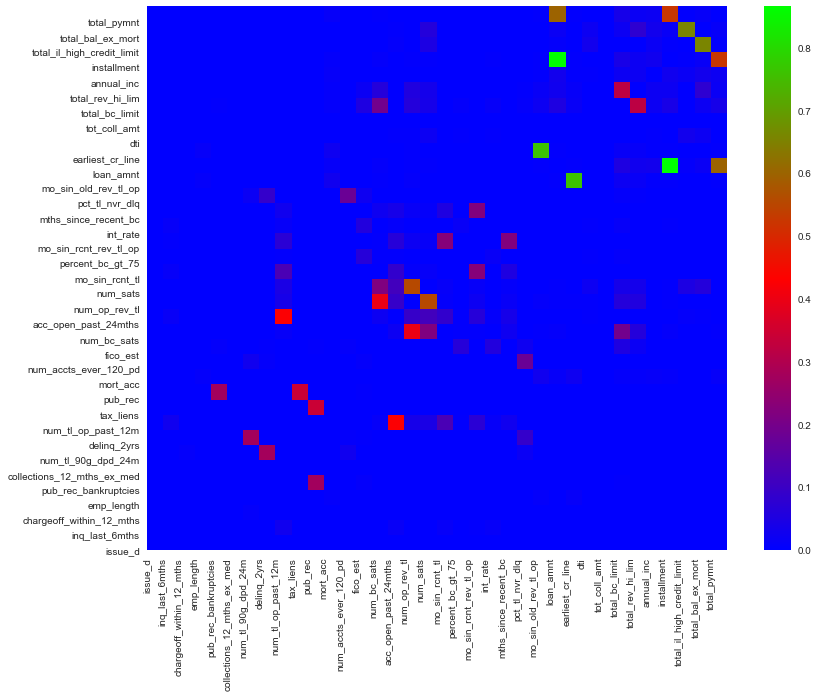

In [21]:
reduc_corr_columns = corr_columns.copy()

reduc_corr_columns[]
to_remove = revolving.copy()
to_remove += ['grade'] # Extra code to drop grade

to_remove.remove('total_rev_hi_lim')
for x in to_remove:
    reduc_corr_columns.remove(x)

corr_df=nonnan_df[reduc_corr_columns]

matrix=np.corrcoef(corr_df,rowvar=False)-np.eye(len(corr_df.columns))


i,j=np.nonzero(abs(matrix) > 0.7)
print("Factors with high correlation (> +/-0.7) are:")
for k in range(len(i)):
    print("\t",k,corr_df.columns[i[k]],"vs",corr_df.columns[j[k]],"=",matrix[i[k]][j[k]])
    

# cube each value to highlight higher correlation elements
matrix=abs(matrix**3)
plt.figure(figsize=(13,10))
plt.pcolor(matrix,cmap='brg')

plt.xticks(range(len(corr_df.columns)), corr_df.columns,rotation='vertical')
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.colorbar(cmap='brg')
plt.show()

Notes:
- We still see some multicolinearity with the loan payment section. I plan to address additional factors in the factoring for income section.
- Total payments is one of the planned Y variables. For instances where it has high correlation, we expect to see strong relationships.


# Factoring for income
The correlation matrix emphasizes some factors in the data are highly correlated. In some instances, this correlation may be due to the fact that the predictors are dependent on other predictors. For example, we can consider three predictors in concert: the income, the loan repayment and the interest rate assigned by Lending Club. We are assuming that a higher amount of risk is related to a higher interest rate. That is to say, Lending Club assesses that loans are riskier based on loan to income ratio.

In [24]:
# Shows the relationship between loan repayment and income:
features = ['annual_inc','installment','int_rate']

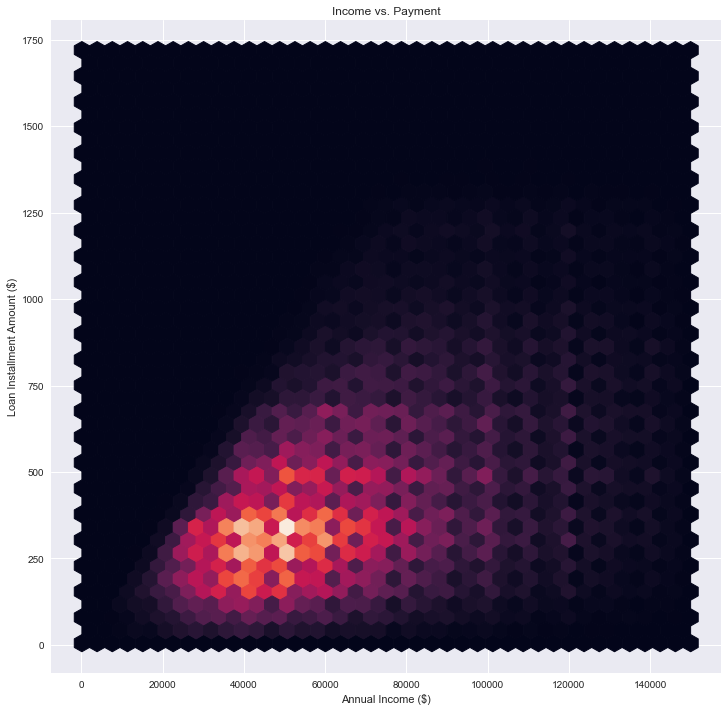

In [25]:
# Large outliers make the trend difficult to understand so I'm making a trimmed df
temp_df = nonnan_df[nonnan_df['annual_inc']<150000][['installment','annual_inc']]
x = temp_df['annual_inc']
y = temp_df['installment']
plt.figure(figsize=(12,12))
plt.hexbin(x,y,gridsize =40)
plt.xlabel('Annual Income ($)')
plt.ylabel('Loan Installment Amount ($)')
plt.title('Income vs. Payment')
plt.show()

While it looks like income and loan amount are both approximately normally distributed, we see that there is a clear fan pattern here. No monthly loan payment is larger than approximately 1% of annual income. We may be able to keep valuable information from both datasets and reduce multicolinearity by considering not the individuals variables, but the relationships between them.

In [30]:
nonnan_df['percent_of_income'] = nonnan_df['installment']*12/nonnan_df['annual_inc']
nonnan_df['percent_of_income'].describe()

count    890319.000000
mean          0.078960
std           0.058134
min           0.000123
25%           0.047090
50%           0.072569
75%           0.104865
max          31.792800
Name: percent_of_income, dtype: float64

Because we see some odd cases, I looked up an extreme and found that we see odd values when considering joint incomes. These instances are rare (fewer than 40 cases where total payments are greater than total income). This loan was funded as a joint application. As a result we are going to have to throw out any data about joint applications as it only represents 8000 cases, but creates significant leverage points.

In [29]:
# Testing an extreme example from the
df.iloc[1542746]

index                                                                                     18648
id                                                                                    115381037
member_id                                                                                   NaN
loan_amnt                                                                                 10000
funded_amnt                                                                               10000
funded_amnt_inv                                                                           10000
term                                                                                  60 months
int_rate                                                                                 20.00%
installment                                                                              264.94
grade                                                                                         D
sub_grade                               

In [36]:
nonnan_df = nonnan_df[nonnan_df['application_type_Joint App']==0]

In [48]:
# Additional factors to remove
if 'installment' not in to_remove:
    to_remove += ['installment']
    to_remove += ['total_pymnt','loan_amnt']
features = list(set(nonnan_df.columns) - set(to_remove))

# Let's work with training and test sets

In [49]:
print(df.shape,nonnan_df.shape)

# need to look at interest rate as well!!!
y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
traintest_df=nonnan_df[features]

X_train, X_test, y_train, y_test = train_test_split(
    traintest_df,y,test_size=0.2,random_state=42)#,stratify=nonnan_df[['loan_status']])

Xscaler = StandardScaler()
Xscaler.fit_transform(X_train,X_test)

print(X_train.shape,X_test.shape)

(1873317, 153) (882243, 71)
(705794, 60) (176449, 60)


In [50]:
# your code here

pca = PCA(n_components=.95,svd_solver="full")
principalComponents = pca.fit(X_train)

print("PCA used %d components to capture >95%% variance."% len(pca.components_))
print("Total variance captured = %f." % pca.explained_variance_ratio_.sum())
#print(principalComponents.components_)

X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)


PCA used 4 components to capture >95% variance.
Total variance captured = 0.961132.


In [51]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

28.769521306066117
[-3.00969413e-04 -3.53564848e-08  1.56603079e-02 -1.53703915e-07
 -8.84635057e-04 -7.33924760e-04  1.08767629e-03  6.64829381e-09
 -1.37332967e-02  4.65441568e-05  2.08525300e-02  8.24463327e-13
 -7.14099863e-03 -2.97833806e-05 -1.31922640e-07 -8.68555946e-03
  6.45998404e-04  3.30257824e-05  9.62501419e-08  3.35091458e-03
 -1.06086905e-03  5.27634918e-05 -3.13984949e-15 -3.16210382e-04
  2.33468664e-07  2.16512060e-02 -5.89632789e-03  1.46819925e-02
 -1.60455684e-06  1.21642582e-03  2.07275828e-05 -2.35438573e-03
  9.30678636e-03 -1.73353983e-02  1.72004765e-05 -3.19093023e-04
 -7.10101760e-05 -1.37550230e-02 -1.23293908e-02 -4.70383179e-05
 -1.44363006e-03 -1.25698825e-01 -2.03819779e-03 -3.71826908e-03
  2.58981882e-03  1.73472348e-17 -2.22961653e-03 -1.23305351e-04
  2.63573879e-04 -5.96093302e-06 -3.97167405e-03 -1.93678609e-02
 -2.52525914e-02  7.77387329e-05 -6.93889390e-18 -1.84588405e-02
 -1.43951916e-02 -6.96369744e-03  3.16954680e-02 -1.80998089e-02]
The t

In [52]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 5
intercept = 28.77279351685247
betas = [-2.98740034e-04 -3.51064763e-08  1.56320967e-02 -1.53767699e-07
 -8.83133185e-04 -7.35653270e-04  1.08448502e-03  6.65250929e-09
 -1.36385228e-02  4.65443062e-05  1.74914292e-02  0.00000000e+00
 -7.05134845e-03 -2.96654354e-05 -1.31681647e-07 -8.61098195e-03
  6.46394944e-04  3.30497580e-05  9.63546155e-08  3.35103751e-03
 -1.06000974e-03  5.27517631e-05  0.00000000e+00 -3.16311422e-04
  2.33831356e-07  1.82970818e-02 -5.82321360e-03  1.13254264e-02
 -1.60339484e-06  1.21506106e-03  2.08312144e-05 -2.35288250e-03
  5.13881657e-03 -1.72944845e-02  1.71128487e-05 -3.19279824e-04
 -7.08578468e-05 -1.37549990e-02 -1.22308995e-02 -4.70435969e-05
 -1.34196924e-03 -1.24282692e-01 -2.03624484e-03 -3.71606665e-03
  2.58919623e-03  0.00000000e+00 -2.22813731e-03 -1.23829462e-04
  2.64179914e-04 -7.20024444e-06 -3.88856261e-03 -1.92643960e-02
 -2.48757371e-02  7.74434870e-05  0.00000000e+00 -1.84589154e-02
 -1.43950239e-02 -6.8

In [53]:
LCLRModel = LassoCV(alphas=lambdas, cv=kfold)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = 27.047912587403612
betas = [ 0.00000000e+00 -1.31983071e-08  0.00000000e+00 -1.55955788e-07
 -4.88597760e-04 -8.92543409e-04  2.00389331e-05  6.95819249e-09
 -0.00000000e+00  4.66231206e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.98312916e-06 -9.59162544e-08 -0.00000000e+00
  2.24726858e-04  2.21357261e-05  1.01654320e-07  0.00000000e+00
 -9.76778871e-04  5.07605643e-05  0.00000000e+00 -0.00000000e+00
  2.54780591e-07  0.00000000e+00  0.00000000e+00 -1.75407886e-03
 -1.40731815e-06 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -4.53397102e-03  3.51993247e-06 -2.19891704e-04
 -3.08862271e-05 -1.28951023e-02 -0.00000000e+00 -4.78015997e-05
  0.00000000e+00 -0.00000000e+00 -1.66671713e-04 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  3.27974901e-04  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  4.25661265e-05  0.00000000e+00 -6.91906275e-03
 -4.97867031e-03

In [54]:
coef_df=pd.DataFrame(np.array([X_train.columns,
                               LCOLSModel.coef_,
                               LCRRModel.coef_,
                               LCLRModel.coef_]).T,columns=["feature","OLS","RR","LR"])

In [55]:
print(coef_df)

                                feature          OLS           RR           LR
0                              mort_acc -0.000300969  -0.00029874            0
1                            annual_inc -3.53565e-08 -3.51065e-08 -1.31983e-08
2                       purpose_wedding    0.0156603    0.0156321            0
3                     total_bal_ex_mort -1.53704e-07 -1.53768e-07 -1.55956e-07
4                    num_tl_op_past_12m -0.000884635 -0.000883133 -0.000488598
5                                   dti -0.000733925 -0.000735653 -0.000892543
6                              int_rate   0.00108768   0.00108449  2.00389e-05
7                          tot_coll_amt  6.64829e-09  6.65251e-09  6.95819e-09
8                purpose_small_business   -0.0137333   -0.0136385           -0
9                           total_pymnt  4.65442e-05  4.65443e-05  4.66231e-05
10                   home_ownership_OWN    0.0208525    0.0174914            0
11           application_type_Joint App  8.24463e-13

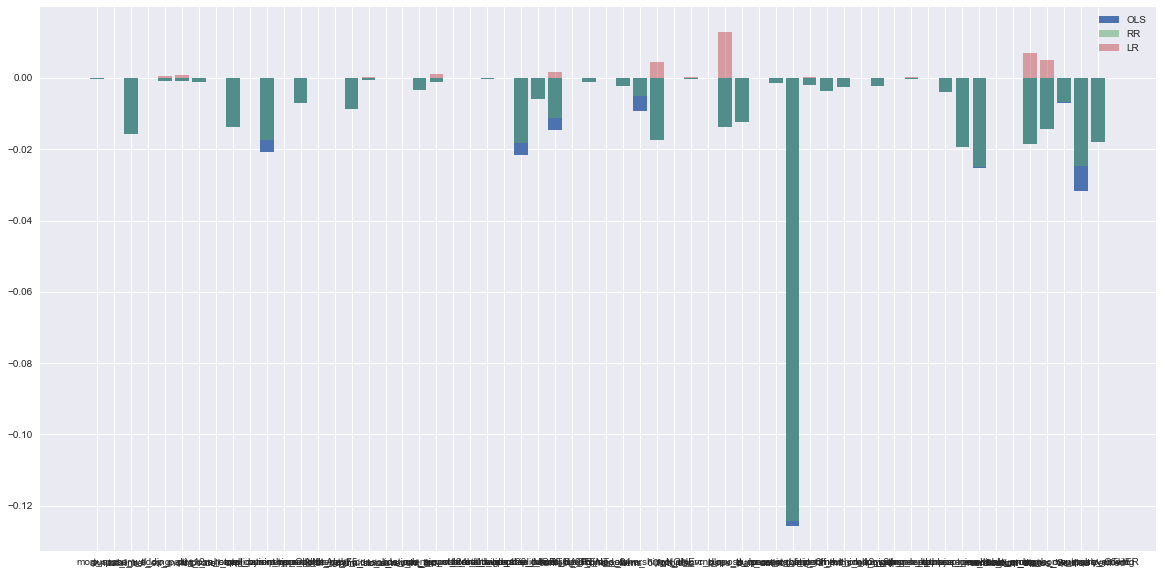

In [56]:
# your code here
plt.figure(figsize=(20,10))
plt.bar(coef_df["feature"],-abs(coef_df["OLS"]),label='OLS',alpha=1.0)
plt.bar(coef_df["feature"],-abs(coef_df["RR"]),label='RR',alpha=0.5)
plt.bar(coef_df["feature"],abs(coef_df["LR"]),label='LR',alpha=0.5)
plt.yscale("linear")

plt.legend()
plt.show()

# Code for cleanup in the future

In [57]:
order=sorted(has_data, key=lambda dict_key: has_data[dict_key])

for i in order:
    print(i, has_data[i])

annual_inc_joint 9529
dti_joint 9529
mths_since_last_record 172185
mths_since_recent_bc_dlq 240759
mths_since_last_major_derog 264308
mths_since_rcnt_il 289098
all_util 296067
inq_last_12m 296092
open_acc_6m 296092
total_cu_tl 296092
inq_fi 296093
open_il_12m 296093
open_il_24m 296093
open_rv_12m 296093
open_rv_24m 296093
mths_since_recent_revol_delinq 338379
mths_since_last_delinq 503506
mths_since_recent_inq 881746
mo_sin_old_il_acct 924972
pct_tl_nvr_dlq 952881
mo_sin_old_rev_tl_op 953024
mo_sin_rcnt_rev_tl_op 953024
num_rev_accts 953024
mo_sin_rcnt_tl 953025
num_accts_ever_120_pd 953025
num_bc_tl 953025
num_il_tl 953025
num_op_rev_tl 953025
num_rev_tl_bal_gt_0 953025
num_tl_90g_dpd_24m 953025
num_tl_op_past_12m 953025
tot_coll_amt 953025
tot_hi_cred_lim 953025
total_il_high_credit_limit 953025
total_rev_hi_lim 953025
percent_bc_gt_75 962805
bc_open_to_buy 963125
mths_since_recent_bc 963842
num_bc_sats 964711
num_sats 964711
emp_length 965386
acc_open_past_24mths 973271
mort_acc 973

# Heat map Visualizations

In [58]:
#Explore the loan status versus purpose
import seaborn as sns; sns.set()

purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[purp_loan[0]], df[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
purpose,,,,,,,,,
car,1621,8918,0,13,51,9496,95,35,166
credit_card,38804,185798,7,69,271,182070,2503,813,3511
debt_consolidation,129606,449458,10,292,808,470267,8431,2766,11680
educational,56,1,0,32,65,270,0,0,0
home_improvement,11703,58019,3,71,143,53007,859,295,1249
house,1089,4832,0,11,33,4072,88,34,126
major_purchase,4047,19217,0,23,100,17818,259,108,468
medical,2535,10865,0,22,36,8669,169,69,266
moving,1715,5464,1,15,31,5486,118,38,165


In [59]:
# Explore the loan status versus loan grade
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_grade[0]], df[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,10831,40038,64493,47643,29714,12257,3681
Current,150647,252131,250946,105350,39290,10482,3348
Default,0,5,14,2,2,1,0
Does not meet the credit policy. Status:Charged Off,8,85,148,197,158,93,72
Does not meet the credit policy. Status:Fully Paid,90,269,481,494,378,154,122
Fully Paid,160994,254370,222484,108832,46641,14794,3780
In Grace Period,765,2929,4902,2934,1447,469,188
Late (16-30 days),252,963,1602,1011,520,186,68
Late (31-120 days),1032,3884,6880,4292,2222,871,354


In [60]:
#Explore the loan status versus home ownership
loan_home = ['loan_status', 'home_ownership']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_home[0]], df[loan_home[1]]).style.background_gradient(cmap = cm)


home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,33,89406,7,27,22586,96598
Current,341,399110,1,0,95966,316776
Default,0,8,0,0,2,14
Does not meet the credit policy. Status:Charged Off,0,348,1,11,49,352
Does not meet the credit policy. Status:Fully Paid,0,908,4,27,138,911
Fully Paid,124,417473,40,117,83520,310621
In Grace Period,6,6421,1,0,1592,5614
Late (16-30 days),0,2148,0,0,605,1849
Late (31-120 days),8,8282,0,0,2481,8764


In [61]:
#Exploring the loan_status versus loan application_type
loan_application = ['loan_status', 'application_type']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[loan_application[0]], df[loan_application[1]]).style.background_gradient(cmap = cm)

application_type,Individual,Joint App
loan_status,,
Charged Off,206689,1968
Current,756226,55968
Default,23,1
Does not meet the credit policy. Status:Charged Off,761,0
Does not meet the credit policy. Status:Fully Paid,1988,0
Fully Paid,804334,7561
In Grace Period,12553,1081
Late (16-30 days),4278,324
Late (31-120 days),18382,1153


In [62]:
#Exploring the State Address versus Loan Status
adress_loan = ['addr_state', 'loan_status']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(df[adress_loan[0]], df[adress_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
addr_state,,,,,,,,,
AK,504,1846,0,1,4,2021,34,6,53
AL,3109,9644,0,8,24,9630,178,64,270
AR,1869,6123,0,6,9,5752,99,36,173
AZ,4950,18364,0,18,33,19889,309,101,498
CA,30436,104027,5,101,223,122155,1655,588,2663
CO,3626,16037,0,13,52,19244,209,85,306
CT,2623,14159,0,12,50,12043,271,89,283
DC,367,1729,0,2,8,2386,36,11,32
DE,570,2339,0,4,18,2233,51,16,75


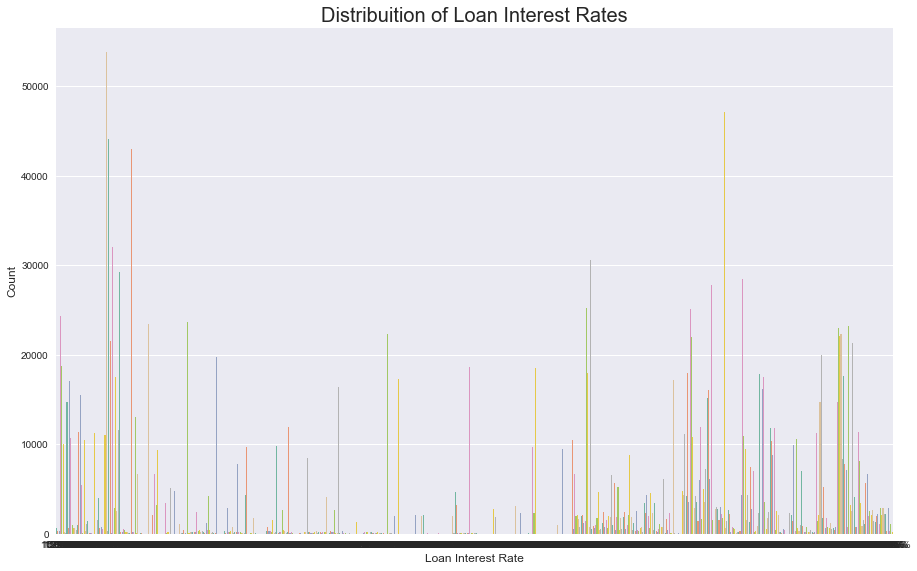

In [63]:
# Explore distrubution of loan interest rates
plt.figure(figsize = (15,12))
plt.subplot(211)
g1 = sns.countplot(x="int_rate",data=df, 
                   palette="Set2")
g1.set_xlabel("Loan Interest Rate", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Distribuition of Loan Interest Rates", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 1.2,top = 2)

plt.show()

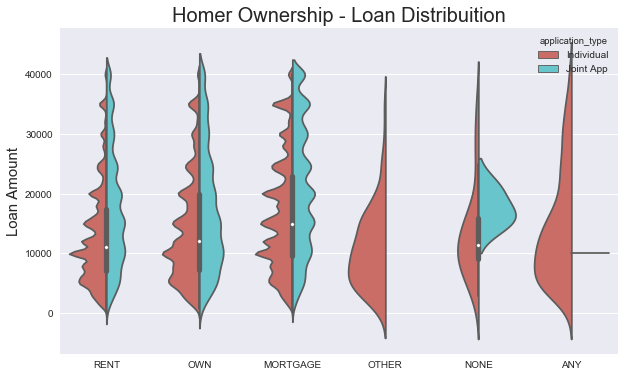

In [64]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="home_ownership",y="loan_amnt",data=df,
               kind="violin",
               split=True,palette="hls",
               hue="application_type")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

Purposes count description: 
application_type    Individual  Joint App
purpose                                  
car                      19829        566
credit_card             401026      12820
debt_consolidation     1031471      41847
educational                424          0
home_improvement        120451       4898
house                     9988        297
major_purchase           40716       1324
medical                  21452       1179
moving                   12570        463
other                   110453       3703
renewable_energy          1195         38
small_business           20836        616
vacation                 12469        304
wedding                   2354          1


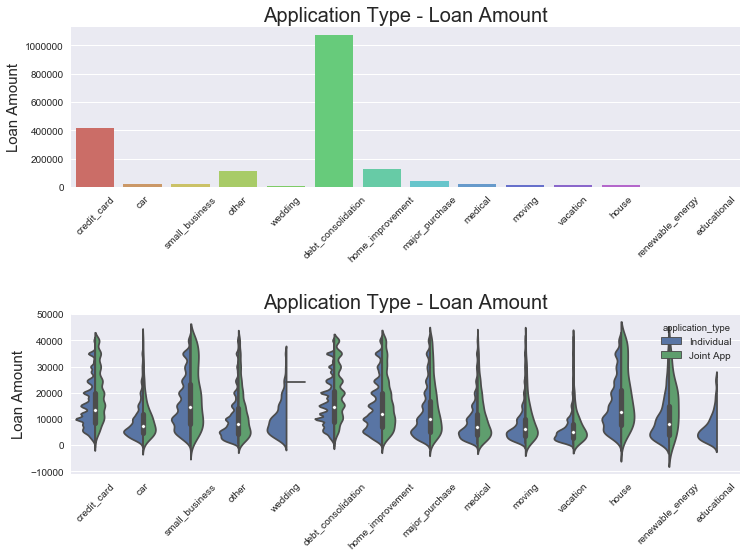

In [65]:
# Explore Loan Purpose
print("Purposes count description: ")
print(pd.crosstab(df.purpose, df.application_type))

plt.figure(figsize = (12,8))

plt.subplot(211)
g = sns.countplot(x="purpose",data=df,
                  palette='hls')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Application Type - Loan Amount", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.subplot(212)
g1 = sns.violinplot(x="purpose",y="loan_amnt",data=df,
               hue="application_type", split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_title("Application Type - Loan Amount", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

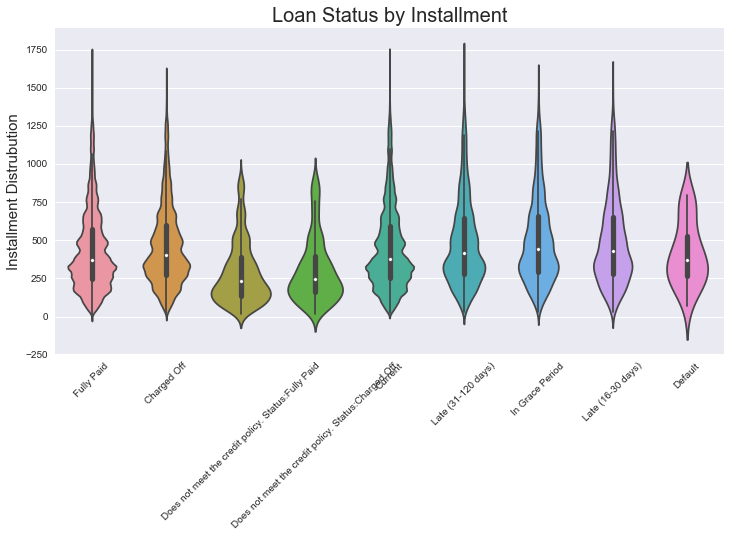

In [66]:
plt.figure(figsize = (12,6))

g = sns.violinplot(x='loan_status', y="installment",
                   data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Installment Distrubution", fontsize=15)
g.set_title("Loan Status by Installment", fontsize=20)

plt.show()

In [67]:
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'NMCP Fully Paid'
df.loc[df.loan_status == \
            'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'NMCP Charged Off'

Current               812194
Fully Paid            811895
Charged Off           208657
Late (31-120 days)     19535
In Grace Period        13634
Late (16-30 days)       4602
NMCP Fully Paid         1988
NMCP Charged Off         761
Default                   24
Name: loan_status, dtype: int64


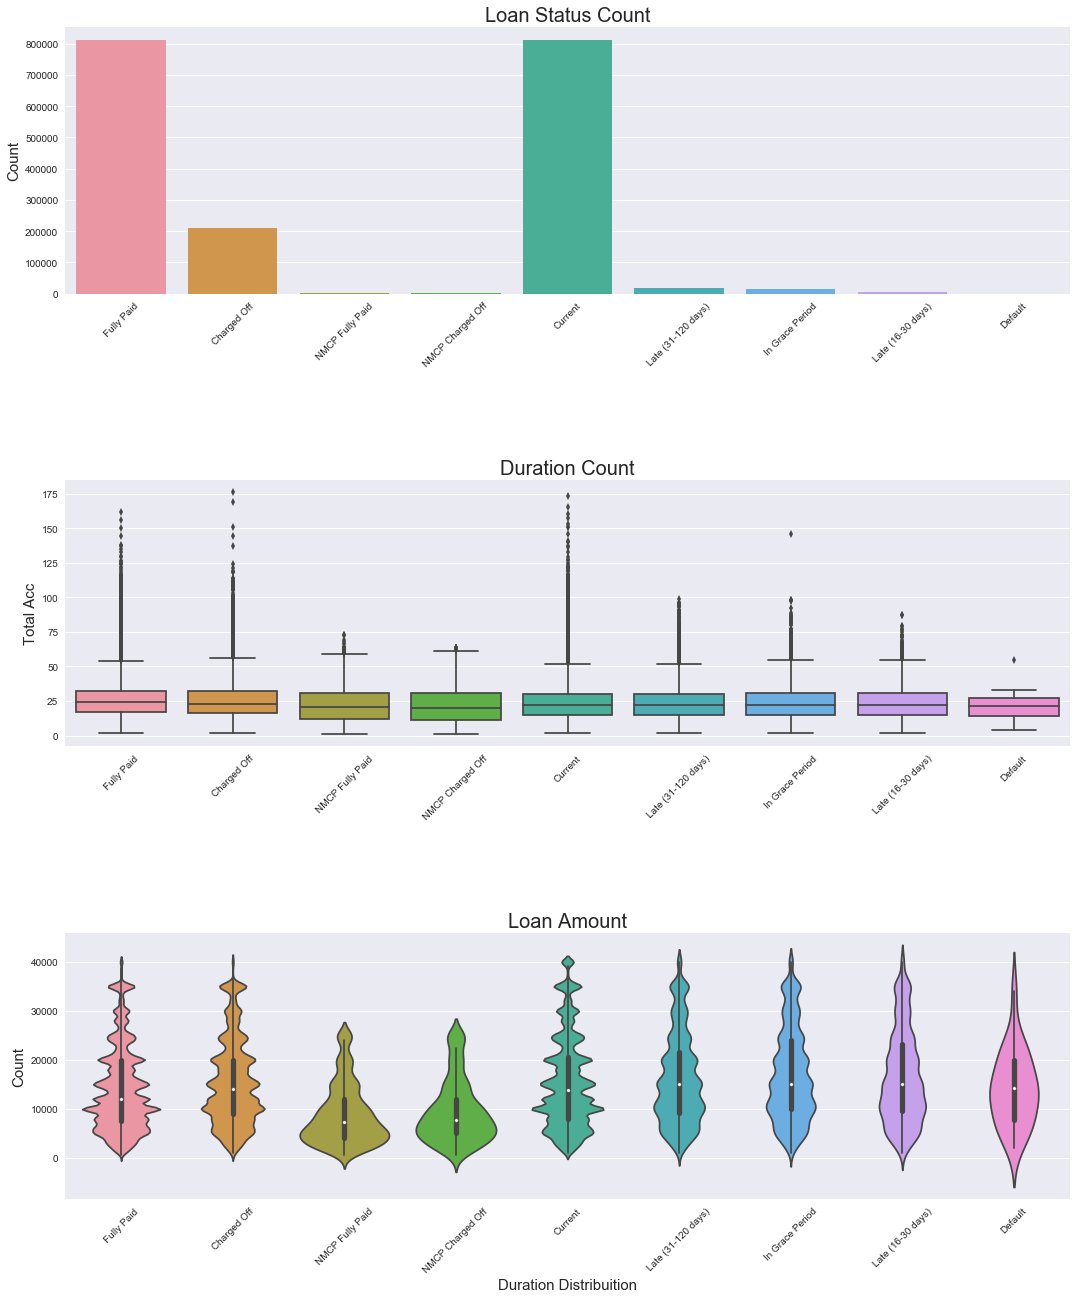

In [68]:
print(df.loan_status.value_counts())

plt.figure(figsize = (18,21))

plt.subplot(311)
g = sns.countplot(x="loan_status", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Count", fontsize=20)

plt.subplot(312)
g1 = sns.boxplot(x="loan_status", y="total_acc", data=df)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Total Acc", fontsize=15)
g1.set_title("Duration Count", fontsize=20)

plt.subplot(313)
g2 = sns.violinplot(x="loan_status", y="loan_amnt", data=df)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Duration Distribuition", fontsize=15)
g2.set_ylabel("Count", fontsize=15)
g2.set_title("Loan Amount", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

plt.show()